# GAP Reconstruction

Reconstructing timestamp using the logfile. We identify the regions of interest, and the UTC times they occur in and then proceed with plugging them back to the data and fixing the time. In particular we are focused on the gaps in the rate when the threshold is zero

In [1]:
# import necessary modules
import matplotlib.pyplot as plt
import raadpy as rp
import numpy as np
import os


# Define some constants
raw_dir = '../../Data/FULL_DATA/'
# SD      = '2022-09-19' 
# raw_dir = '../../Data/Light-1/light1-'+SD+'/'

# Get the subfiles and put the in a dictionary
fnames      = os.listdir(raw_dir)
filenames   = {}
for i in range(1,10): 
    res = [name for name in fnames if f'buff{i}' in name]
    if len(res)>0: filenames[f'buff{i}'] = res[0]
for name in fnames: 
    if 'log' in name: filenames['log'] = name

print(filenames)

%matplotlib widget

{'buff1': 'light1-2022-03-04-buff1.dat', 'buff2': 'light1-2022-08-04-buff2.dat', 'buff3': 'light1-2022-08-02-buff3.dat', 'buff4': 'light1-2022-03-04-buff4.dat', 'buff5': 'light1-2022-03-04-buff5.dat', 'buff6': 'light1-2022-03-08-buff6.dat', 'buff7': 'light1-2022-03-08-buff7.dat', 'log': 'light1-se-log.txt'}


In [2]:
# Directory of the buffer
# buffer_fname    = raw_dir + SD + '/light1-'+SD+'-buff1.dat'
# Or:
buffer_fname    = raw_dir + filenames['buff1']

SIPM_ID     = 0
PMT_ID      = 1
PAYLOAD_ID  = PMT_ID

# Decode the buffer data in a dictionary
full_data   = rp.get_dict(buffer_fname,struct=rp.ORBIT_STRUCT,condition=f"data['id_bit'] == {PAYLOAD_ID}")

Line:   0%|          | 0/296753 [00:00<?, ?it/s]

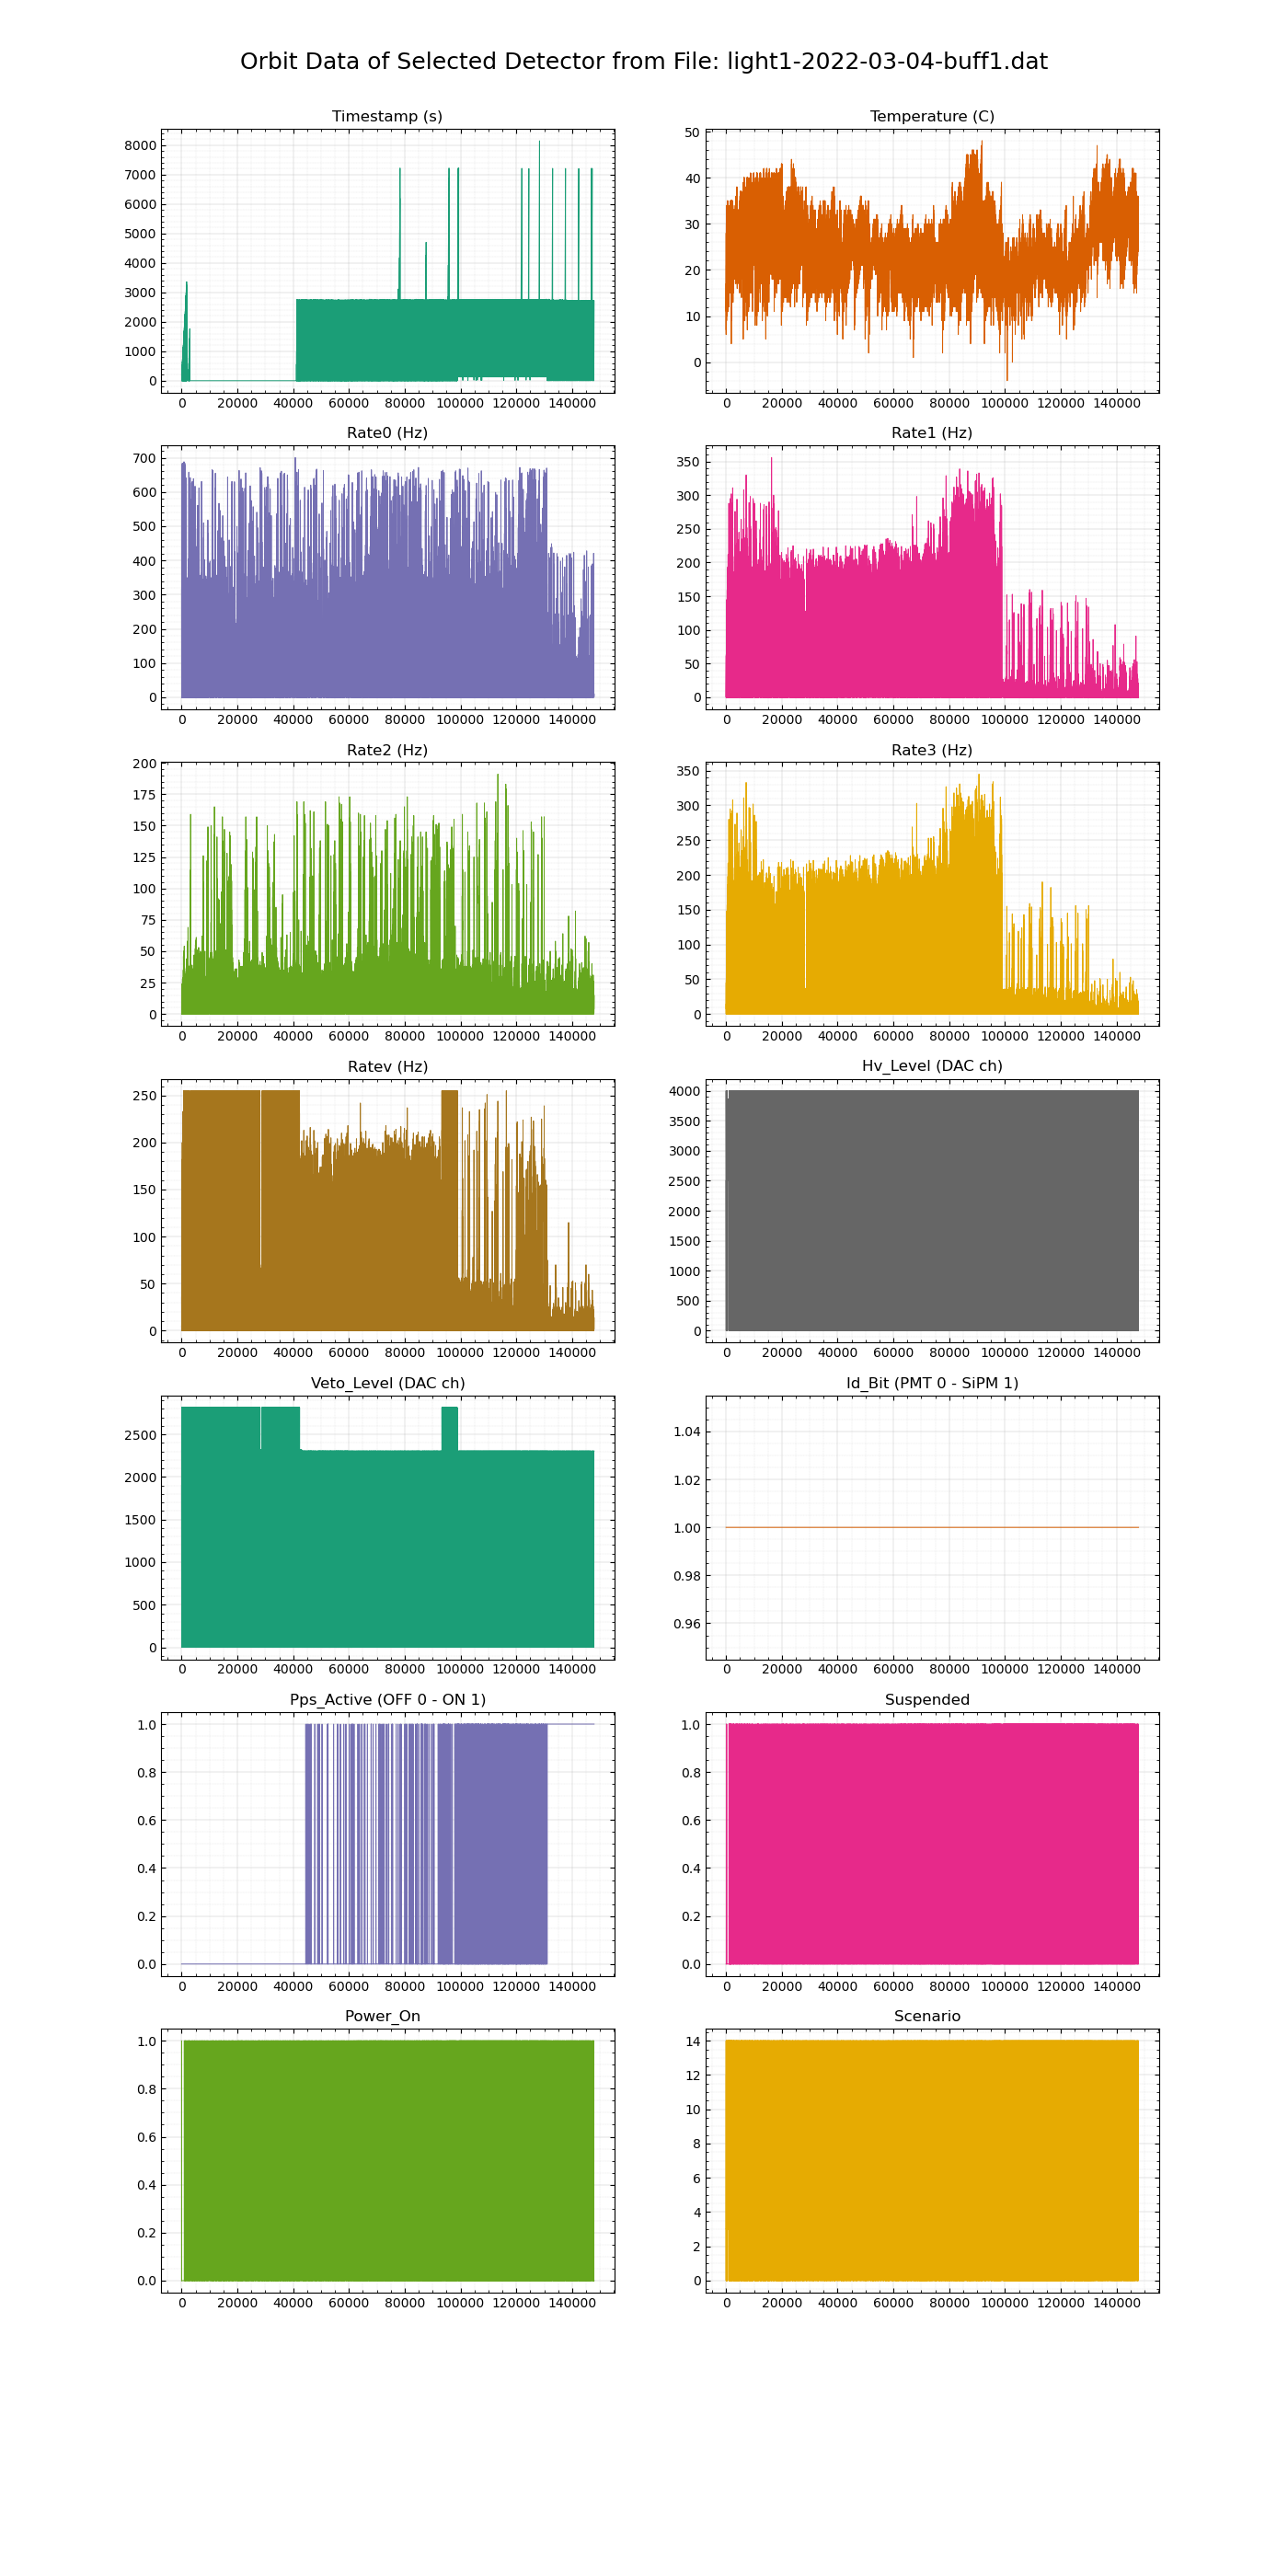

In [3]:
# Now print the Data
fig, axes  = rp.plot_buffer(full_data,title = 'Orbit Data of Selected Detector from File: '+ filenames['buff1'],UNITS=rp.ORBIT_UNITS)

In [4]:
# Clip the data to the regions of interest
TAIL    = 12000
data    = rp.subdict(full_data,-TAIL)

# Now we load the log file and find it's timestamps
log     = rp.log_expand(filename=raw_dir+filenames['log'])      # Load the logfile
log     = log[-int(TAIL/len(full_data['timestamp'])*3 * len(log)):]
log     = rp.log_with_timestamp(log)                            # Find the timestamp each command finished executing

Found weird command
 {'command': 'SE0>rtc read\n', 'output': ['curr rtc time 166247script delayuntil 1662516900\n', 'OK\n']}
Found weird command
 {'command': 'SE0>rtc read\n', 'output': ['curr rtc time 16657438script delayuntil 1665756900\n', 'OK\n']}
Found weird command
 {'command': 'SE0>script delay 18script delayuntil 1666075500\n', 'output': ['OK\n']}


In [5]:
# Helper functions #############################################

# Get the two arrays of different size and match their elements
def match(*arrays,from_end=True):
    # Length of the final arrays
    length = min([len(array) for array in arrays])

    # Concatenate the arrays
    if from_end:
        return [array[-length:] for array in arrays]
    else: 
        return [array[:length] for array in arrays]

# Collect timestamps of command execution
def collect_time_cmd(log:dict,cmd,include_end:bool=True):
    return np.array([line['timestamp'] for line in log if cmd in line['command']])

# Remove the dublicates
def remove_duplicates(array,mean:float=1,std:float=1,return_idx:bool=False,only_zeros:float=float('inf')):
    diff    = array[1:] - array[:-1]
    idx     = np.where(diff > mean*np.mean(diff) + std*np.std(diff))[0]
    idx     = np.array([i for i in idx if abs(array[i+1]) <= only_zeros])

    if return_idx: return idx
    return array[idx]

# Take an array and return an increasing version of it
def force_increasing(array):
    add     = 0
    output  = array.copy()
    for i in range(1,len(array)):
        if array[i] - array[i-1] < 0: add += array[i-1]
        output[i] += add

    return output

In [6]:
# Find the peaks in the timestamp
end_timestamps_idx      = remove_duplicates(-data['timestamp'],return_idx=True)           # Array of indices of the peaks
end_timestamps_idx      = np.append(end_timestamps_idx,[len(data['timestamp']) - 1])                    # Append the last index because it is a peak
start_timestamps_idx    = end_timestamps_idx[:-1] + 1

# Find the peaks in the logfile
PWR_ON_CMD              = 'txrx 4 14 600 0007010100'
PWR_OFF_CMD             = 'txrx 4 14 600 0007000000'
end_timestamps_log      = collect_time_cmd(log,PWR_OFF_CMD)
start_timestamps_log    = collect_time_cmd(log,PWR_ON_CMD)

In [7]:
# Match the two arrays from the back
end_timestamps_idx, end_timestamps_log, start_timestamps_idx, start_timestamps_log = match(end_timestamps_idx,end_timestamps_log,start_timestamps_idx,start_timestamps_log)

In [8]:
# Fill in the gaps in the logfile

# Nomralize the logfile
normed_timestamps = data['timestamp'].copy().astype('float')

# Normalize by tooth
for s,e in zip(start_timestamps_idx,end_timestamps_idx):
    normed_timestamps[s:e+1]    = force_increasing(normed_timestamps[s:e+1])
    temp_timestamp              = force_increasing(data['timestamp'][s:e+1])
    normed_timestamps[s:e+1]    = (normed_timestamps[s:e+1]- min(normed_timestamps[s:e+1]))/float(temp_timestamp[-1]-temp_timestamp[0])

# Finaly get the stupid timestamp
timestamp = []

# For each tooth
for i,(s,e) in enumerate(zip(start_timestamps_idx,end_timestamps_idx)):
    # For each element within the tooth
    min_time = start_timestamps_log[i]
    max_time = end_timestamps_log[i]
    for j in range(s,e+1):
        timestamp.append(normed_timestamps[j]*(max_time-min_time) + min_time)

timestamp = np.array(timestamp)

In [9]:
for line in log:
    # if PWR_OFF_CMD in line['command']:
    print("%20f\t"%line['timestamp'],line['command'][:-1],"\t")

            0.000000	 SE0>csp txrx 12 8 3000 00 	
           10.000000	 SE0>script delay 10000 	
           10.000000	 SE0>csp txrx 13 8 3000 00 	
           40.000000	 SE0>script delay 30000 	
   1662455218.046631	 SE0>rtc read 	
   1662455218.046631	 SE0>csp txrx 12 9 3000 0B0B0009400F001690010016 	
   1662455228.046631	 SE0>script delay 10000 	
   1662455228.046631	 SE0>csp txrx 13 9 3000 0F0F0009B80B501308076810 	
   1662455268.046631	 SE0>script delay 40000 	
   1662455268.046631	 SE0>csp txrx 12 9 3000 0B0B0009400F001690010016 	
   1662455278.000946	 SE0>script delay 10000 	
   1662455278.000946	 SE0>csp txrx 13 9 3000 0F0F0009B80B501308076810 	
   1662455278.000946	 SE0>rtc read 	
   1662455282.500458	 SE0>script delay 4500 	
   1662455282.500458	 SE0>rtc read 	
   1662457500.000000	 SE0>script delayuntil 1662457500 	
   1662457500.008087	 SE0>rtc read 	
   1662457500.008087	 SE0>csp txrx 12 4 3000 08 	
   1662457510.008087	 SE0>script delay 10000 	
   1662457510.008087	 SE0>csp

Text(0.5, 0.98, 'Reconstructed Time vs event number')

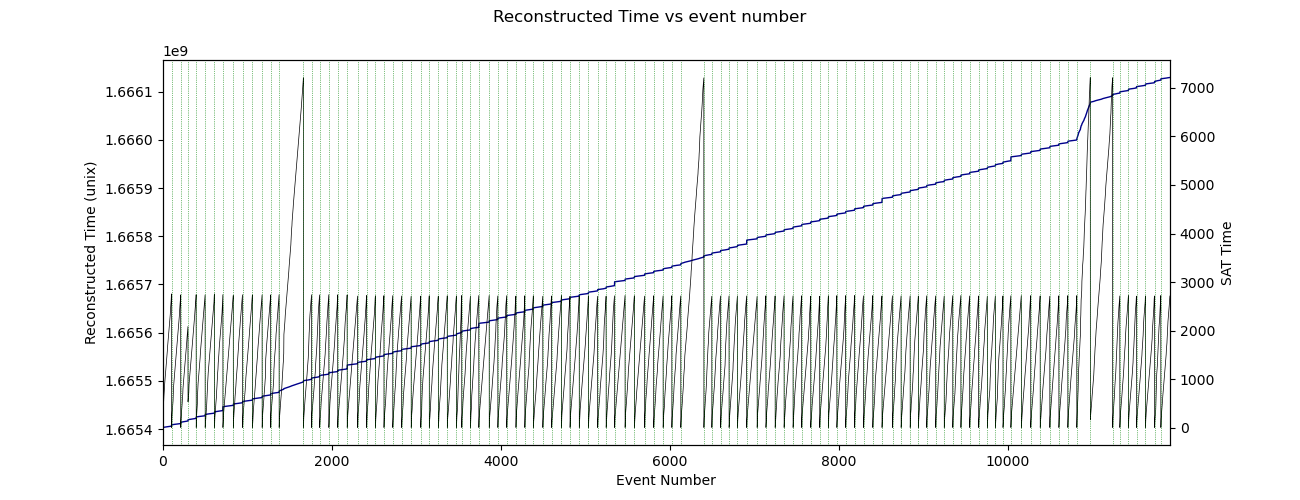

In [10]:
fig = plt.figure(figsize=(13,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

MIN = start_timestamps_idx[0]

ax1.plot(timestamp,c='darkblue',lw=1)
ax2.plot(data['timestamp'][MIN:],lw=0.5,c='k')
for i in start_timestamps_idx:
    ax2.axvline(i - MIN,c='g',lw=0.5,ls=':')

ax1.set_ylabel('Reconstructed Time (unix)')
ax2.set_ylabel('SAT Time')
ax1.set_xlabel('Event Number')
ax2.set_xlim(0,TAIL - MIN)
fig.suptitle('Reconstructed Time vs event number')


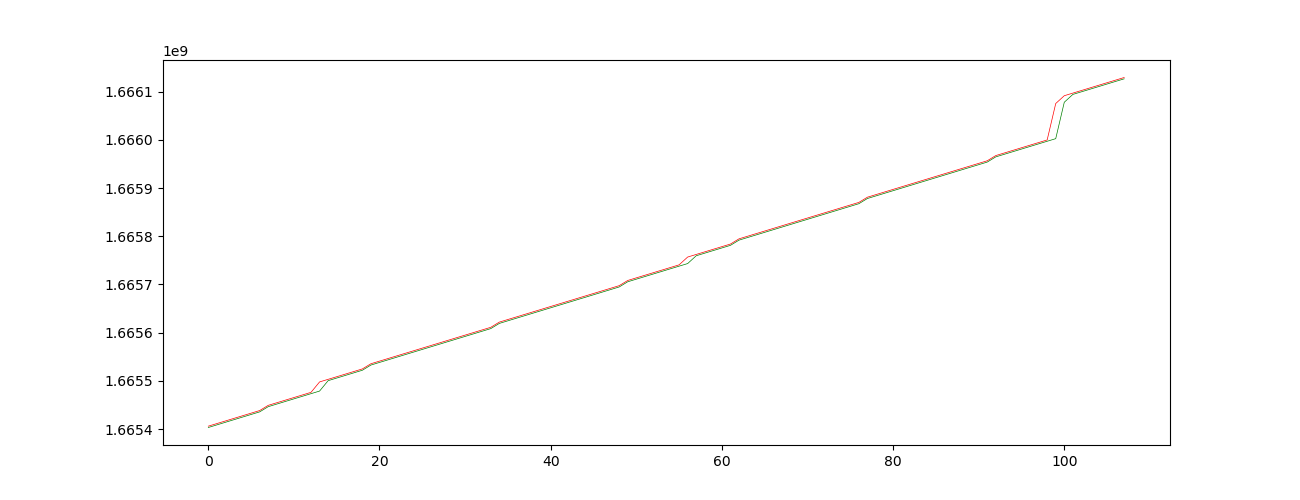

In [11]:
fig = plt.figure(figsize=(13,5))
plt.plot(start_timestamps_log,c='g',lw=0.5)
plt.plot(end_timestamps_log,  c='r',lw=0.5)


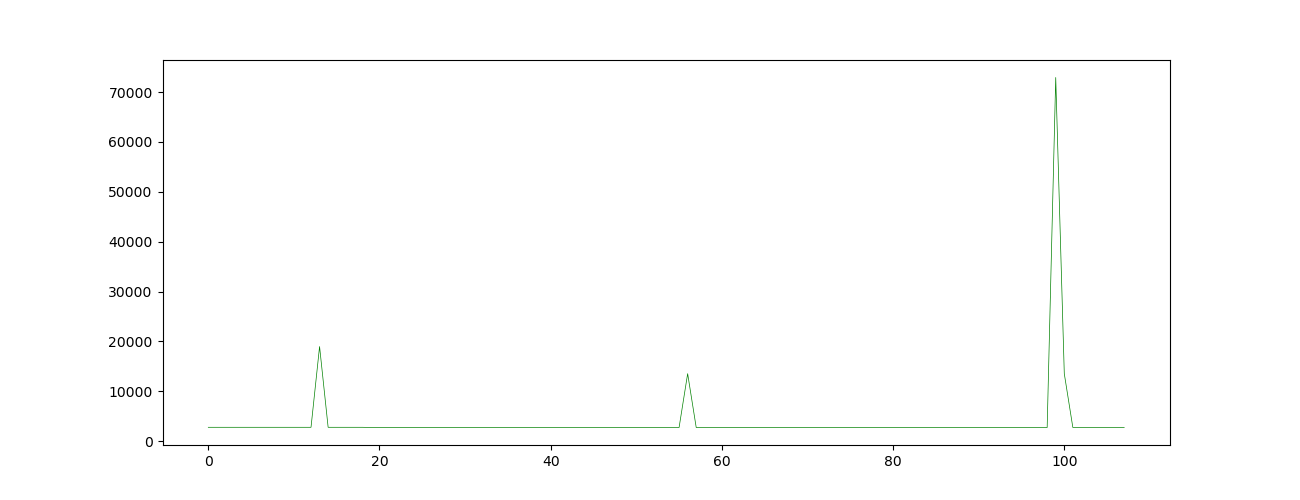

In [12]:
fig = plt.figure(figsize=(13,5))
plt.plot(end_timestamps_log-start_timestamps_log,c='g',lw=0.5)


In [13]:
# Convert to astropy object time
time_astro = [rp.Time(t,format='unix') for t in timestamp]# if  MIN <= t <= MAX]
print(len(time_astro))

# Get the location of the cubesat in this time
positions = rp.get_light1_position(min(time_astro),max(time_astro),n_events=10*len(time_astro))

11917


In [14]:
# Interpolate positions
def interpolate(array,timestamps):
    new_array   = rp.array([])
    old_time    = array.get_timestamps(format='unix')
    longs,lats  = array.get_coords().T
    for t in timestamps:
        new_array.append(rp.event(
            timestamp = rp.Time(t,format='unix'),
            latitude  = np.interp(t,old_time,lats),
            longitude = np.interp(t,old_time,longs),
            detector_id=0,
        ))

    return new_array

positions = interpolate(positions,timestamp)

In [56]:
rates = 0
for i in range(4): rates += data[f'rate{i}'][range(min(start_timestamps_idx),max(end_timestamps_idx)+1)]
 
log_rates = np.array([2*max(0,np.log(r)) for r in rates])

temperatures = np.array(data['temperature'][min(start_timestamps_idx):max(end_timestamps_idx)+1])

# rp.map(positions,color=rates,marker_size=log_rates,size=800)

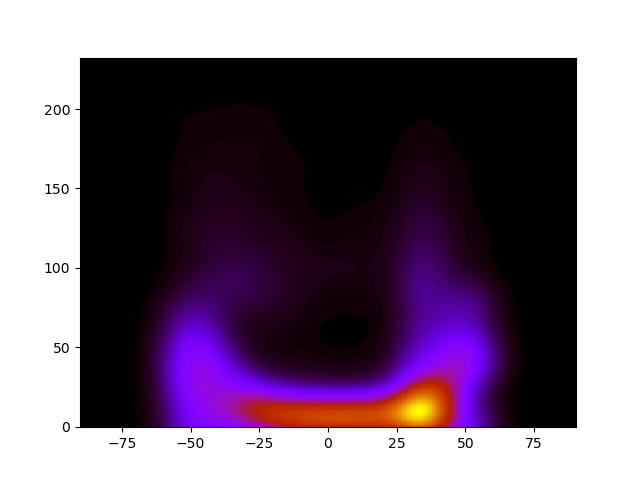

In [57]:
from scipy.stats import kde

latitudes = positions.get_coords().T[1]
nbins=300

a,b = np.histogram(latitudes,bins=nbins)

k = kde.gaussian_kde([latitudes,rates])
xi, yi = np.mgrid[-90:90:nbins*1j, 0:max(rates)*0.5:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

plt.figure()
plt.pcolormesh(xi, yi, zi.reshape(xi.shape),  shading='auto', cmap=plt.cm.gnuplot)
plt.show()

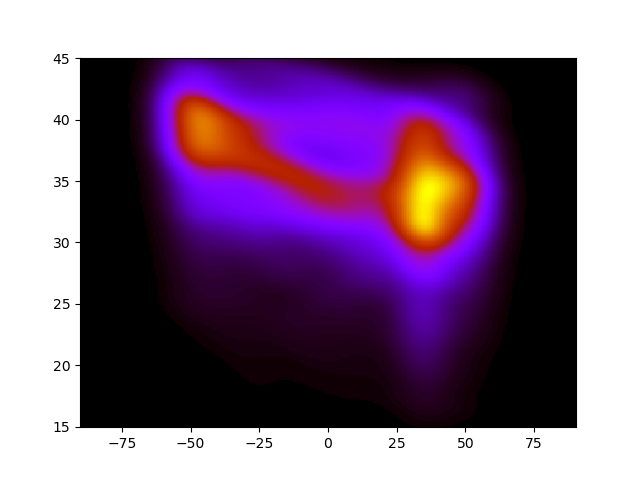

In [53]:
nbins=300

k = kde.gaussian_kde([latitudes,temperatures])
xi, yi = np.mgrid[-90:90:nbins*1j, min(temperatures):max(temperatures):nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

plt.figure()
plt.pcolormesh(xi, yi, zi.reshape(xi.shape),  shading='auto', cmap=plt.cm.gnuplot)
plt.show()

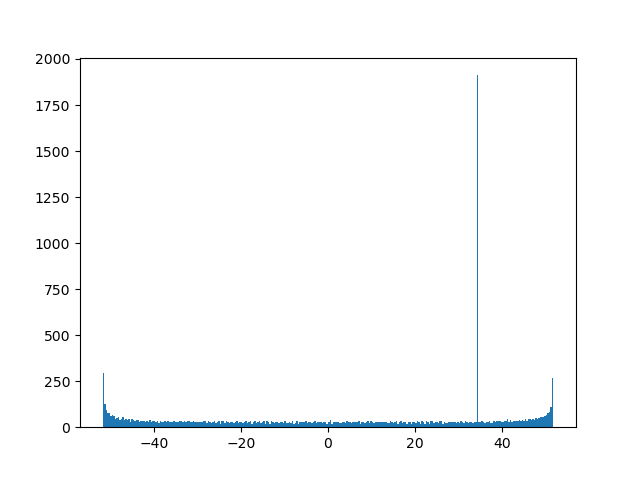

In [25]:
plt.figure()
v = plt.hist(latitudes,bins=300);

296